# Car Fuel Classification

## Importing Required Libraries

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
)
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

## Defining the functions and methods to be used

In [ ]:
def get_list_paths(path: str, start_char: str = None) -> list:
    """
    Get the list of paths from a directory, optionally filtering files that start with a specific character.

    Args:
        path (str): Path to the directory.
        start_char (str, optional): The character with which the files should start. Defaults to None.

    Returns:
        list: List of paths to files ending with '.csv'. If 'start_char' is provided, only files that start with that character will be included.
    """

    if start_char:
        return [os.path.join(path, file) for file in os.listdir(path) if file.startswith(start_char) and file.endswith(".csv")]
    else:
        return [os.path.join(path, file) for file in os.listdir(path) if file.endswith(".csv")]


def read_selected_data(list_paths: list, columns: list) -> pd.DataFrame:
  """
    Read all the data with .csv extension from the list of paths and return a list of dataframes,
    selecting only specified columns.

    Args:
        list_paths (list): List of paths to the data.
        columns (list): List of columns to be included in the returned dataframes.

    Returns:
        list: List of dataframes (one dataframe per file), with selected columns.
  """
  # List comprehension to read each csv file and select only the specified columns
  return [pd.read_csv(path, usecols=columns) for path in list_paths if ".csv" in path]

def concatenate_dataframes(list_df: list) -> pd.DataFrame:
    """
    Concatenate a list of dataframes.

    Args:
        list_df (list): List of dataframes.

    Returns:
        pd.DataFrame: Dataframe with all the dataframes concatenated.
    """

    return pd.concat(list_df, ignore_index=True)

def is_convertible_to_float(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Split
def split_data(df, train_size, valid_size, test_size):
    # Primeira divisão: separando treino do restante
    df_train, df_temp = train_test_split(df, train_size=train_size, shuffle=True, random_state=42)
    # Ajustando as proporções para a divisão seguinte
    proportion = valid_size / (valid_size + test_size)
    # Segunda divisão: separando validação e teste
    df_valid, df_test = train_test_split(df_temp, train_size=proportion, shuffle=True, random_state=42)
    return df_train, df_valid, df_test


# Data Shift
def split_columns_into_three(df, column_names, classification_column):
    new_df = pd.DataFrame()

    for column_name in column_names:
        # Create new column names
        col_t0 = f"{column_name}_(t-2)"
        col_t1 = f"{column_name}_(t-1)"
        col_t2 = f"{column_name}_(t)"

        # Create new columns based on the original column
        new_df[col_t0] = df[column_name]
        new_df[col_t1] = df[column_name].shift(-1)
        new_df[col_t2] = df[column_name].shift(-2)

    # Drop rows with NaN values (optional, depending on your needs)
    new_df.dropna(inplace=True)

    # Add the classification column without shifting
    new_df[classification_column] = df[classification_column][:len(new_df)].values

    return new_df

# Remove non numeric data and convert coluns to number
def convert_to_numeric(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df.dropna()

## Train test split

### Selecting columns from a the Training and Validation Data

In [ ]:
from sklearn.model_selection import train_test_split

ethanol_data_final = pd.read_csv('ethanol_fuelType.csv')
gasoline_data_final = pd.read_csv('gasoline_fuelType.csv')

In [ ]:
# Concatenar os datasets de etanol e gasolina
full_data = pd.concat([ethanol_data_final, gasoline_data_final], ignore_index=True)

# Dividir o dataset em treino (80%) e o resto (20%)
train_data, temp_data = train_test_split(full_data, test_size=0.2, stratify=full_data['FuelType'])

# Dividir o resto em validação (60% de 20%, ou seja, 12% do total) e teste (40% de 20%, ou seja, 8% do total)
validation_data, test_data = train_test_split(temp_data, test_size=0.4, stratify=temp_data['FuelType'])

# Verificar a distribuição das classes em cada subset
print("Distribuição em treino:\n", train_data['FuelType'].value_counts())
print("\nDistribuição em validação:\n", validation_data['FuelType'].value_counts())
print("\nDistribuição em teste:\n", test_data['FuelType'].value_counts())


Distribuição em treino:
 FuelType
1    331556
0     73946
Name: count, dtype: int64

Distribuição em validação:
 FuelType
1    49734
0    11091
Name: count, dtype: int64

Distribuição em teste:
 FuelType
1    33156
0     7395
Name: count, dtype: int64


In [ ]:
test_data.columns.to_list()

['EngineLoad_(t-2)',
 'EngineLoad_(t-1)',
 'EngineLoad_(t)',
 'EngineRPM_(t-2)',
 'EngineRPM_(t-1)',
 'EngineRPM_(t)',
 'SpeedOBD_(t-2)',
 'SpeedOBD_(t-1)',
 'SpeedOBD_(t)',
 'ThrottlePosition_(t-2)',
 'ThrottlePosition_(t-1)',
 'ThrottlePosition_(t)',
 'TimingAdvance_(t-2)',
 'TimingAdvance_(t-1)',
 'TimingAdvance_(t)',
 'FuelType']

In [ ]:
# Selecionar colunas para normalização
feature_columns = ['EngineLoad_(t-2)', 'EngineLoad_(t-1)', 'EngineLoad_(t)',
                   'EngineRPM_(t-2)', 'EngineRPM_(t-1)', 'EngineRPM_(t)',
                   'SpeedOBD_(t-2)', 'SpeedOBD_(t-1)', 'SpeedOBD_(t)',
                   'ThrottlePosition_(t-2)', 'ThrottlePosition_(t-1)', 'ThrottlePosition_(t)',
                   'TimingAdvance_(t-2)', 'TimingAdvance_(t-1)', 'TimingAdvance_(t)']

# Lista para armazenar a média e o desvio padrão de cada coluna
scaler_stats = []

# Função para normalizar as colunas
def custom_standard_scaler(df, feature_columns):
    for column in feature_columns:
        mean = df[column].mean()
        std = df[column].std()
        df[column] = (df[column] - mean) / std
        scaler_stats.append((column, mean, std))

# Aplicar a função de normalização
custom_standard_scaler(train_data, feature_columns)
custom_standard_scaler(validation_data, feature_columns)
custom_standard_scaler(test_data, feature_columns)

# Verificar os valores armazenados
for stat in scaler_stats:
    print(f"Coluna: {stat[0]}, Média: {stat[1]}, Desvio Padrão: {stat[2]}")


Coluna: EngineLoad_(t-2), Média: 34.0430989162089, Desvio Padrão: 23.172842009545292
Coluna: EngineLoad_(t-1), Média: 34.05292408181891, Desvio Padrão: 23.17732262154569
Coluna: EngineLoad_(t), Média: 34.065653447269995, Desvio Padrão: 23.19079196688356
Coluna: EngineRPM_(t-2), Média: 1619.2306745712722, Desvio Padrão: 670.8209472937956
Coluna: EngineRPM_(t-1), Média: 1619.3330291835798, Desvio Padrão: 670.7766090391244
Coluna: EngineRPM_(t), Média: 1619.3625037607706, Desvio Padrão: 670.7717291743279
Coluna: SpeedOBD_(t-2), Média: 43.51039205725249, Desvio Padrão: 35.53271211739068
Coluna: SpeedOBD_(t-1), Média: 43.51028108369379, Desvio Padrão: 35.53135209785578
Coluna: SpeedOBD_(t), Média: 43.515477112320035, Desvio Padrão: 35.529159974509525
Coluna: ThrottlePosition_(t-2), Média: 19.613544437299744, Desvio Padrão: 8.219163033503852
Coluna: ThrottlePosition_(t-1), Média: 19.61740183080767, Desvio Padrão: 8.224078127798172
Coluna: ThrottlePosition_(t), Média: 19.62102281988043, Desvi

In [ ]:
#train_data.to_csv('Norm_Train_Dataset.csv', index=False)
#validation_data.to_csv('Norm_Valid_Dataset.csv', index=False)
test_data.to_csv('Norm_Test_Dataset.csv', index=False)

In [ ]:
seed = 2610

In [ ]:
train_data.columns

Index(['EngineLoad_(t-2)', 'EngineLoad_(t-1)', 'EngineLoad_(t)',
       'EngineRPM_(t-2)', 'EngineRPM_(t-1)', 'EngineRPM_(t)', 'SpeedOBD_(t-2)',
       'SpeedOBD_(t-1)', 'SpeedOBD_(t)', 'ThrottlePosition_(t-2)',
       'ThrottlePosition_(t-1)', 'ThrottlePosition_(t)', 'TimingAdvance_(t-2)',
       'TimingAdvance_(t-1)', 'TimingAdvance_(t)', 'FuelType'],
      dtype='object')

In [ ]:
X_train = train_data[['EngineLoad_(t-2)', 'EngineLoad_(t-1)', 'EngineLoad_(t)',
                    'EngineRPM_(t-2)', 'EngineRPM_(t-1)', 'EngineRPM_(t)',
                    'SpeedOBD_(t-2)','SpeedOBD_(t-1)', 'SpeedOBD_(t)',
                    'ThrottlePosition_(t-2)', 'ThrottlePosition_(t-1)', 'ThrottlePosition_(t)',
                    'TimingAdvance_(t-2)', 'TimingAdvance_(t-1)', 'TimingAdvance_(t)']]
y_train = train_data['FuelType']

X_valid = validation_data[['EngineLoad_(t-2)', 'EngineLoad_(t-1)', 'EngineLoad_(t)',
                    'EngineRPM_(t-2)', 'EngineRPM_(t-1)', 'EngineRPM_(t)',
                    'SpeedOBD_(t-2)','SpeedOBD_(t-1)', 'SpeedOBD_(t)',
                    'ThrottlePosition_(t-2)', 'ThrottlePosition_(t-1)', 'ThrottlePosition_(t)',
                    'TimingAdvance_(t-2)', 'TimingAdvance_(t-1)', 'TimingAdvance_(t)']]
y_valid = validation_data['FuelType']

In [ ]:
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Size of X_valid:", len(X_valid))
print("Size of y_valid:", len(y_valid))

print("Unic classes in y_valid:", y_train.unique())
print("Unic classes in y_valid:", y_valid.unique())

Size of X_train: 164688
Size of y_train: 164688
Size of X_valid: 24703
Size of y_valid: 24703
Unic classes in y_valid: [0 1]
Unic classes in y_valid: [0 1]


In [ ]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(random_state=seed),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Naive Bayes (Bernoulli)": BernoulliNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=seed),
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "Extra Trees": ExtraTreesClassifier(random_state=seed)
}

In [ ]:
results = []

for name, clf in classifiers.items():
  print("Model name:", name)
  print(f"Classifier: {clf} \n")
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_valid)
  report = classification_report(y_valid, y_pred, output_dict=True)
  confusion = confusion_matrix(y_valid, y_pred)
  results.append({
      "Classifier": name,
      "Classification Report": report,
      "Confusion Matrix": confusion
  })

Model name: Random Forest
Classifier: RandomForestClassifier(random_state=2610) 

Model name: Decision Tree
Classifier: DecisionTreeClassifier(random_state=2610) 

Model name: KNN
Classifier: KNeighborsClassifier() 

Model name: Logistic Regression
Classifier: LogisticRegression(random_state=2610) 

Model name: Naive Bayes (Gaussian)
Classifier: GaussianNB() 

Model name: Naive Bayes (Bernoulli)
Classifier: BernoulliNB() 

Model name: Gradient Boosting
Classifier: GradientBoostingClassifier(random_state=2610) 

Model name: AdaBoost
Classifier: AdaBoostClassifier(random_state=2610) 



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model name: Extra Trees
Classifier: ExtraTreesClassifier(random_state=2610) 



In [ ]:
results_df = pd.DataFrame(results)
results_df

,Classifier,Classification Report,Confusion Matrix
0,Random Forest,"{'0': {'precision': 0.9536598209583992, 'recal...","[[9055, 2050], [440, 13158]]"
1,Decision Tree,"{'0': {'precision': 0.8263119665879789, 'recal...","[[9101, 2004], [1913, 11685]]"
2,KNN,"{'0': {'precision': 0.8921854571055013, 'recal...","[[8871, 2234], [1072, 12526]]"
3,Logistic Regression,"{'0': {'precision': 0.8465708522440747, 'recal...","[[6715, 4390], [1217, 12381]]"
4,Naive Bayes (Gaussian),"{'0': {'precision': 0.8204665161775772, 'recal...","[[5452, 5653], [1193, 12405]]"
5,Naive Bayes (Bernoulli),"{'0': {'precision': 0.590179254099057, 'recall...","[[6947, 4158], [4824, 8774]]"
6,Gradient Boosting,"{'0': {'precision': 0.9417442261289211, 'recal...","[[8196, 2909], [507, 13091]]"
7,AdaBoost,"{'0': {'precision': 0.8952808988764045, 'recal...","[[7968, 3137], [932, 12666]]"
8,Extra Trees,"{'0': {'precision': 0.9711431742508324, 'recal...","[[8750, 2355], [260, 13338]]"


## Best Model Performance

Accuracy of Random Forest: 0.8992025260089868


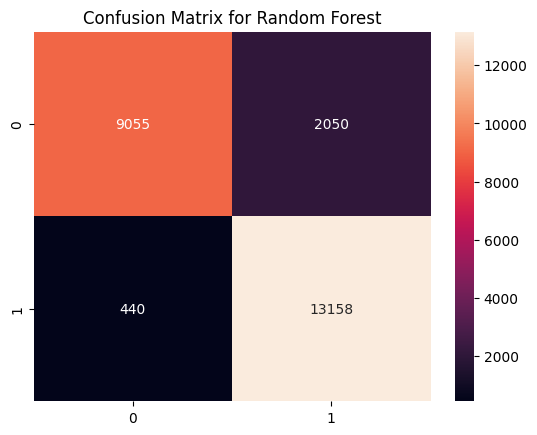

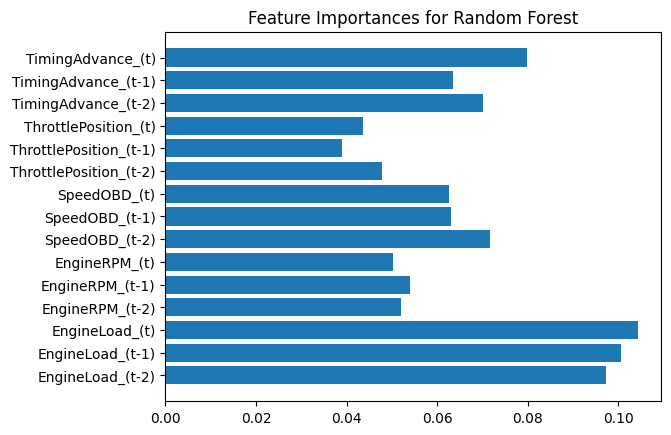

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88     11105
           1       0.87      0.97      0.91     13598

    accuracy                           0.90     24703
   macro avg       0.91      0.89      0.90     24703
weighted avg       0.90      0.90      0.90     24703



In [ ]:
random_forest = RandomForestClassifier(random_state=seed)
random_forest.fit(X_train, y_train)

rf_pred = random_forest.predict(X_valid)
rf_accuracy = accuracy_score(y_valid, rf_pred)
print('Accuracy of Random Forest:', rf_accuracy)

conf_mat = confusion_matrix(y_valid, rf_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix for Random Forest')
plt.show()

importances = random_forest.feature_importances_
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.title('Feature Importances for Random Forest')
plt.show()

report = classification_report(y_valid, rf_pred)
print('Classification Report for Random Forest:\n', report)

## Prunning Best Model

Accuracy for the prunned Random Forest model: 0.8742662834473546
Classification report for the prunned Random Forest model:
               precision    recall  f1-score   support

     Ethanol       0.97      0.75      0.84     11105
    Gasoline       0.82      0.98      0.90     13598

    accuracy                           0.87     24703
   macro avg       0.90      0.86      0.87     24703
weighted avg       0.89      0.87      0.87     24703



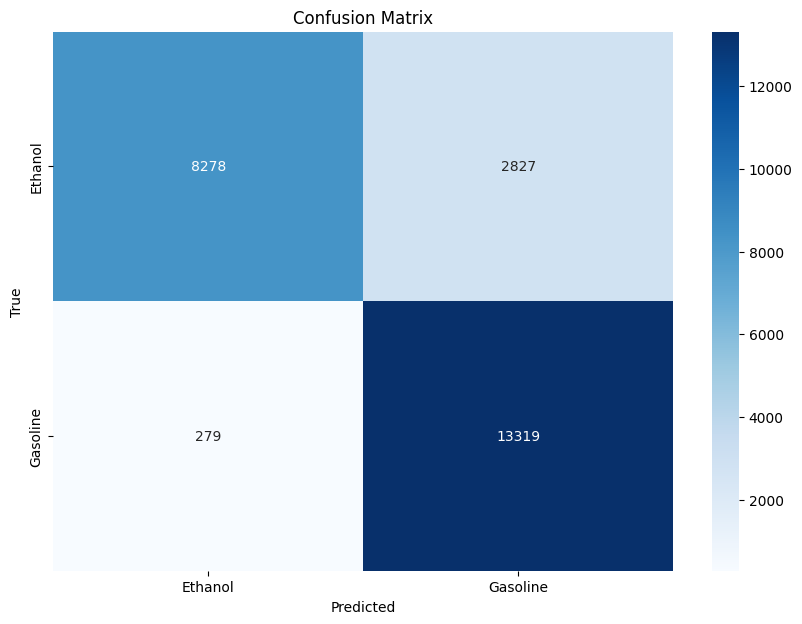

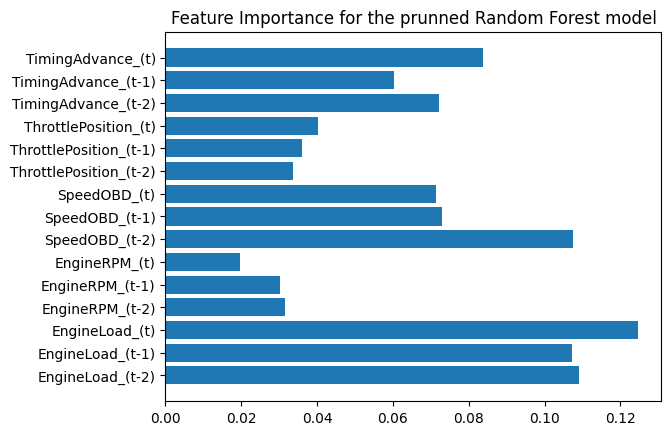

In [ ]:
random_forest_emb = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0001,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features='sqrt',
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    n_estimators=38,
    n_jobs=None,
    oob_score=True,
    random_state=seed,
    verbose=0,
    warm_start=False,
)


random_forest_emb.fit(X_train, y_train)

rf_pred = random_forest_emb.predict(X_valid)

rf_accuracy = accuracy_score(y_valid, rf_pred)
print('Accuracy for the prunned Random Forest model:', rf_accuracy)

report = classification_report(y_valid, rf_pred, target_names=['Ethanol', 'Gasoline'])
print('Classification report for the prunned Random Forest model:\n', report)

conf_mat = confusion_matrix(y_valid, rf_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=['Ethanol', 'Gasoline'], yticklabels=['Ethanol', 'Gasoline'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

importances = random_forest_emb.feature_importances_
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.title('Feature Importance for the prunned Random Forest model')
plt.show()

In [ ]:
# 38 -> 78.17

## Embedding Prunned Model

In [ ]:
!pip install micromlgen>=1.1.26

In [ ]:
from micromlgen import port, port_testset

In [ ]:
file_path_default = 'classifier_default.h'
with open(file_path_default, 'w') as file:
  file.write(port(random_forest, classname='RandomForestClassifier', tmp_file='examples/RFC.json'))

file_size_mb = (os.path.getsize(file_path_default)) / (1024 * 1024)
print(f"Memory ocupancy of the model'{file_path_default}': {file_size_mb:.5f} MB")

Memory ocupancy of the model'classifier_default.h': 1637.84160 MB


In [ ]:
file_path = 'classifier.h'
with open(file_path, 'w') as file:
  file.write(port(random_forest_emb, classname='RandomForestClassifier', tmp_file='examples/RFC.json'))

file_size_mb = (os.path.getsize(file_path)) / (1024 * 1024)
print(f"Memory ocupancy of the prunned model'{file_path}': {file_size_mb:.5f} MB")

Memory ocupancy of the prunned model'classifier.h': 3.10261 MB
